# Packages


In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pandas import DataFrame
from pprint import pprint
import datetime

# Gensim
import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import matplotlib.pyplot as plt
import mysql.connector
import pandas.io.sql as psql

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Connection to SQL

In [2]:
conn = mysql.connector.connect(host="ba-isdsclass-dev2.lsu.edu",
                                user="pgutie2",
                                passwd="msadatabase",
                                database="msa_schema")
cursor = conn.cursor()

In [3]:
sql = ("Select * from newdata order by article_date asc;")
db = pd.read_sql(sql,conn)
db

,article_url,article_date,article_title,article_text,author,twitter,timestamp
0,http://blogs.nature.com/methagora/2015/04/meth...,01 Apr 2015,Methods comparisons are hard,SitemapNature Methods | Methagora01 Apr 2015 |...,Natalie de Souza,,2020-03-26 13:44:45
1,http://blogs.nature.com/freeassociation/2015/0...,01 Apr 2015,Sidestepping spurious associations,SitemapNature Genetics | Free Association01 Ap...,Brooke LaFlamme,,2020-03-26 13:44:45
2,http://blogs.nature.com/naturejobs/2016/04/01/...,01 Apr 2016,Most read on Naturejobs: March 2016,SitemapNaturejobs | Naturejobs Blog01 Apr 2016...,Jack Leeming,,2020-03-26 13:43:22
3,http://blogs.nature.com/naturejobs/2016/08/01/...,01 Aug 2016,Five tips to overcome authorship conflict,SitemapNaturejobs | Naturejobs Blog01 Aug 2016...,Jack Leeming,,2020-03-26 13:42:56
4,http://blogs.nature.com/indigenus/2017/08/natu...,01 Aug 2017,Nature India Photo Story: Cubanacan the Litigon,SitemapNature India | Indigenus01 Aug 2017 | 0...,Subhra Priyadarshini,,2020-03-26 13:41:30
...,...,...,...,...,...,...,...
39285,https://www.ewg.org/news/news-releases/2000/09...,"Wednesday, September 6, 2000",Truth Wins Round One: ABC Confirms Stossel's P...,Facebook Twitter Amazon Youtube Instagram Pin...,,,2020-03-26 13:54:24
39286,https://www.ewg.org/news/news-releases/2000/09...,"Wednesday, September 6, 2000",USDA sides with EWG on E. coli,Facebook Twitter Amazon Youtube Instagram Pin...,,,2020-03-26 13:54:24
39287,https://www.ewg.org/release/hidden-carcinogen-...,"Wednesday, September 6, 2017","Hidden Carcinogen Taints Tap Water, Consumer P...",Facebook Twitter Amazon Youtube Instagram Pin...,Alex Formuzis,,2020-03-26 13:51:12
39288,https://www.ewg.org/news/news-releases/2011/09...,"Wednesday, September 7, 2011",FDA Steps Up Pressure on Brazilian Blowout,Facebook Twitter Amazon Youtube Instagram Pin...,,,2020-03-26 13:52:32


# Data Processing

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        #sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        #sent = re.sub('\s+', ' ', sent)  # remove newline chars
        #sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = db.article_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['sitemapnature', 'methods', 'methagora', 'apr', 'pm', 'posted', 'by', 'natalie', 'de', 'souza', 'category', 'editorials', 'general', 'interest', 'nature', 'methods', 'papers', 'statistics', 'comparing', 'methods', 'in', 'fair', 'and', 'informative', 'manner', 'is', 'often', 'not', 'straightforward', 'benchmark', 'data', 'sets', 'thoughtfully', 'applied', 'metrics', 'and', 'clear', 'reporting', 'can', 'help', 'read', 'this', 'month', 'editorial', 'here', 'are', 'there', 'methodological', 'benchmarks', 'you', 'think', 'your', 'community', 'needs', 'there', 'are', 'currently', 'no', 'comments', 'you', 'need', 'to', 'log', 'in', 'or', 'register', 'to', 'comment', 'cell', 'biology', 'editorials', 'featured', 'genetics', 'genomics', 'method', 'of', 'the', 'yeareditorials', 'featured', 'general', 'interest', 'journal', 'happenings', 'nature', 'methods', 'editorials', 'featured', 'journal', 'policyfeatured', 'general', 'interest', 'journal', 'policyfeatured', 'general', 'interest', 'journal'

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



from spacy.lang.en import English

#!python -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load(r'C:\Users\Parker\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.5', disable=['parser', 'ner'])
    # nlp = spacy.load(r'C:\Users\imget\Anaconda3\Lib\site-packages\en_core_web_lg\en_core_web_lg-2.2.5', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for  word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

In [7]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Coherence Calculation

In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)

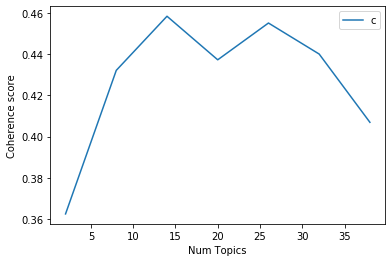

In [10]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3624
Num Topics = 8  has Coherence Value of 0.4322
Num Topics = 14  has Coherence Value of 0.4584
Num Topics = 20  has Coherence Value of 0.4373
Num Topics = 26  has Coherence Value of 0.4552
Num Topics = 32  has Coherence Value of 0.4401
Num Topics = 38  has Coherence Value of 0.4069


In [23]:
ldamodel = LdaModel(corpus=corpus, num_topics=16, id2word=id2word)
ldamodel.show_topics(16)

[(0,
  '0.040*"people" + 0.035*"patient" + 0.026*"case" + 0.023*"virus" + 0.021*"health" + 0.021*"disease" + 0.020*"test" + 0.018*"hospital" + 0.016*"infection" + 0.014*"doctor"'),
 (1,
  '0.133*"child" + 0.055*"vaccine" + 0.046*"parent" + 0.033*"family" + 0.031*"kid" + 0.023*"year" + 0.020*"baby" + 0.017*"autism" + 0.014*"mother" + 0.013*"adult"'),
 (2,
  '0.148*"food" + 0.045*"school" + 0.021*"student" + 0.018*"diet" + 0.018*"obesity" + 0.015*"consumer" + 0.014*"weight" + 0.012*"water" + 0.012*"nutrition" + 0.012*"pain"'),
 (3,
  '0.020*"energy" + 0.019*"job" + 0.016*"year" + 0.016*"story" + 0.015*"industry" + 0.015*"world" + 0.014*"time" + 0.011*"thing" + 0.010*"business" + 0.010*"work"'),
 (4,
  '0.059*"water" + 0.022*"animal" + 0.020*"farm" + 0.018*"farmer" + 0.018*"city" + 0.018*"fish" + 0.014*"people" + 0.014*"area" + 0.012*"wildlife" + 0.012*"photo"'),
 (5,
  '0.070*"bill" + 0.028*"legislation" + 0.018*"vote" + 0.017*"group" + 0.014*"year" + 0.014*"village" + 0.013*"house" + 0.

In [16]:
ldamodel.show_topics(26)

[(0,
  '0.119*"worker" + 0.117*"nurse" + 0.056*"gas" + 0.049*"employee" + 0.042*"cam" + 0.037*"temperature" + 0.034*"employer" + 0.014*"oil" + 0.012*"job" + 0.011*"mapping"'),
 (1,
  '0.078*"student" + 0.046*"school" + 0.024*"image" + 0.016*"class" + 0.013*"practitioner" + 0.012*"college" + 0.012*"team" + 0.011*"eye" + 0.011*"space" + 0.011*"river"'),
 (2,
  '0.029*"funding" + 0.025*"year" + 0.024*"bill" + 0.016*"fund" + 0.014*"government" + 0.014*"gun" + 0.013*"money" + 0.013*"health" + 0.011*"week" + 0.010*"agreement"'),
 (3,
  '0.061*"company" + 0.054*"product" + 0.028*"skin" + 0.026*"bacteria" + 0.025*"device" + 0.020*"claim" + 0.018*"contamination" + 0.015*"investigation" + 0.012*"letter" + 0.011*"market"'),
 (4,
  '0.099*"law" + 0.051*"baby" + 0.034*"abortion" + 0.027*"woman" + 0.026*"pregnancy" + 0.025*"court" + 0.020*"birth" + 0.020*"case" + 0.020*"state" + 0.020*"year"'),
 (5,
  '0.096*"water" + 0.026*"city" + 0.024*"pain" + 0.018*"treatment" + 0.016*"people" + 0.012*"home" + 

In [24]:
top_words_per_topic = []
for t in range(ldamodel.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("new_top_words2.csv")

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

C:\Users\Parker\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.213470  0.064852       1        1  10.148929
17     0.166469 -0.067748       2        1   9.017609
14     0.213963 -0.019553       3        1   6.159485
12     0.024885  0.081055       4        1   5.725814
9      0.119321 -0.102007       5        1   5.634208
8      0.042914  0.021036       6        1   4.847728
10    -0.153613  0.058979       7        1   4.568233
15    -0.139506  0.054566       8        1   4.540389
18     0.063382  0.068352       9        1   4.339762
6      0.071360  0.041055      10        1   4.103878
23    -0.097764  0.146724      11        1   3.850904
16     0.057040  0.140949      12        1   3.674525
2     -0.117476 -0.063441      13        1   3.549814
22    -0.177994 -0.171655      14        1   3.361415
24    -0.043045  0.151194      15        1   3.242136
7     -0.043421  0.081089      16        1   3.242091
21     0.079623 -0.038269      17        1   3.204115
5      0.006702  0.052030      18        1   2.584547
3      0.000955  0.093060      19        1   2.384396
25    -0.044653 -0.044661      20        1   2.111756
19     0.006180 -0.099985      21        1   2.101420
4     -0.083573 -0.021968      22        1   2.094055
1      0.206668 -0.147272      23        1   1.836986
13    -0.141757 -0.033418      24        1   1.774649
20    -0.140374 -0.033907      25        1   1.258322
0     -0.089754 -0.211059      26        1   0.642835, topic_info=     Category          Freq     Term         Total  loglift  logprob
692   Default  36202.000000     drug  36202.000000  30.0000  30.0000
1036  Default  36489.000000    state  36489.000000  29.0000  29.0000
763   Default  39548.000000  patient  39548.000000  28.0000  28.0000
593   Default  97429.000000   health  97429.000000  27.0000  27.0000
126   Default  27132.000000    child  27132.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
39    Topic26    247.785645      day  23372.806641   0.5003  -4.8834
108   Topic26    272.411957     time  43933.734375  -0.0361  -4.7887
519   Topic26    174.073792    night   3967.158936   1.9207  -5.2365
117   Topic26    194.842102     week  20411.605469   0.3954  -5.1238
119   Topic26    167.481461     year  70491.140625  -0.9953  -5.2751

[1870 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3879     19  0.972749       abbvie
6295      6  0.997096  abnormality
1820      1  0.000227     abortion
1820      5  0.001362     abortion
1820      8  0.000227     abortion
...     ...       ...          ...
2036     17  0.018266        youth
2036     18  0.006447        youth
2036     20  0.001074        youth
2036     21  0.002149        youth
4659     22  0.981428        zmapp

[10769 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 18, 15, 13, 10, 9, 11, 16, 19, 7, 24, 17, 3, 23, 25, 8, 22, 6, 4, 26, 20, 5, 2, 14, 21, 1])

In [14]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.9531,"study, people, research, time, science, resear...","[interest, nature, method, paper, statistic, m..."
1,1,13.0,0.9959,"study, people, research, time, science, resear...","[layer, structure, association, test, finding,..."
2,2,13.0,0.6226,"study, people, research, time, science, resear...","[blog, careers_article, week, interview, quest..."
3,3,13.0,0.8334,"study, people, research, time, science, resear...","[blog, faculty, mobility, people, publishing, ..."
4,4,13.0,0.4584,"study, people, research, time, science, resear...","[genetic, photo, story, wildlife, series, phot..."
5,5,13.0,0.9724,"study, people, research, time, science, resear...","[technology, tool, bioinformatic, environment,..."
6,6,3.0,0.8411,"energy, job, year, story, industry, world, tim...","[career, story, community, scientist, platform..."
7,7,13.0,0.9490,"study, people, research, time, science, resear...","[nature, research, month, nature, journal, nat..."
8,8,13.0,0.9546,"study, people, research, time, science, resear...","[day, specie, plant, animal, scientist, specie..."
9,9,3.0,0.5057,"energy, job, year, story, industry, world, tim...","[panel, academic, time, research, time, percen..."


In [20]:
df_dominant_topic['Date']= db['article_date']
df_dominant_topic['Title'] = db['article_title']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date,Title
0,0,12.0,0.5498,"chemical, information, industry, health, worki...","[interest, nature, method, paper, statistic, m...",01 Apr 2015,Methods comparisons are hard
1,1,14.0,0.4890,"research, researcher, animal, study, specie, s...","[layer, structure, association, test, finding,...",01 Apr 2015,Sidestepping spurious associations
2,2,17.0,0.5213,"science, world, time, scientist, conservation,...","[blog, careers_article, week, interview, quest...",01 Apr 2016,Most read on Naturejobs: March 2016
3,3,17.0,0.3661,"science, world, time, scientist, conservation,...","[blog, faculty, mobility, people, publishing, ...",01 Aug 2016,Five tips to overcome authorship conflict
4,4,17.0,0.2977,"science, world, time, scientist, conservation,...","[genetic, photo, story, wildlife, series, phot...",01 Aug 2017,Nature India Photo Story: Cubanacan the Litigon
...,...,...,...,...,...,...,...
39285,39285,3.0,0.3469,"company, product, skin, bacteria, device, clai...","[stone, walling, yesterday, working, allegatio...","Wednesday, September 6, 2000",Truth Wins Round One: ABC Confirms Stossel's P...
39286,39286,12.0,0.3106,"chemical, information, industry, health, worki...","[food, poisoning, test, correspondent, food, k...","Wednesday, September 6, 2000",USDA sides with EWG on E. coli
39287,39287,12.0,0.4425,"chemical, information, industry, health, worki...","[cancer, impurity, cosmetic, sample, state, te...","Wednesday, September 6, 2017","Hidden Carcinogen Taints Tap Water, Consumer P..."
39288,39288,12.0,0.5035,"chemical, information, industry, health, worki...","[working, group, statement, afternoon, company...","Wednesday, September 7, 2011",FDA Steps Up Pressure on Brazilian Blowout


In [21]:
df_dominant_topic.to_csv('new_dominant_topic.csv')

In [18]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7596,"worker, nurse, gas, employee, cam, temperature...","[failure, interview, night]"
1,1.0,0.8711,"student, school, image, class, practitioner, c...","[award, nature, picture, pattern, selection, e..."
2,2.0,0.9850,"funding, year, bill, fund, government, gun, mo...","[appropriator, funding, hearing, debate, issue..."
3,3.0,0.9038,"company, product, skin, bacteria, device, clai...","[regulator, company, consumer, product, firm, ..."
4,4.0,0.9771,"law, baby, abortion, woman, pregnancy, court, ...","[court, ruling, abortion, ban, abortion, metho..."


In [19]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,12.0,"chemical, information, industry, health, worki...",53.0,0.0013
1.0,14.0,"research, researcher, animal, study, specie, s...",303.0,0.0077
2.0,17.0,"science, world, time, scientist, conservation,...",1638.0,0.0417
3.0,17.0,"science, world, time, scientist, conservation,...",658.0,0.0167
4.0,17.0,"science, world, time, scientist, conservation,...",803.0,0.0204
...,...,...,...,...
39285.0,3.0,"company, product, skin, bacteria, device, clai...",NaN,NaN
39286.0,12.0,"chemical, information, industry, health, worki...",NaN,NaN
39287.0,12.0,"chemical, information, industry, health, worki...",NaN,NaN
39288.0,12.0,"chemical, information, industry, health, worki...",NaN,NaN


In [ ]:

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)